<a href="https://colab.research.google.com/github/pranavrao87/Machine-Learning/blob/main/Convolutional%20Neural%20Networks/03_waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Waste Classification using a dataset from Kaggle

Link:
https://www.kaggle.com/datasets/techsash/waste-classification-data?select=DATASET

## Get Data From Kaggle using API Key

In [28]:
# Upload Kaggle API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"prao87","key":"a2bfa89f6777d72984cd8afdc6adbc10"}'}

In [2]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
! kaggle datasets download -d techsash/waste-classification-data

 99% 424M/427M [00:14<00:00, 26.7MB/s]
100% 427M/427M [00:14<00:00, 30.5MB/s]


## Clean and Organize Data

In [4]:
# Extract and unzip the file
zip_ref = zipfile.ZipFile("/content/waste-classification-data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
# Walk through dataset
for dirpath, dirnames, filenames in os.walk("dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'dataset'.
There are 2 directories and 0 images in 'dataset/DATASET'.
There are 2 directories and 0 images in 'dataset/DATASET/TRAIN'.
There are 0 directories and 9999 images in 'dataset/DATASET/TRAIN/R'.
There are 0 directories and 12565 images in 'dataset/DATASET/TRAIN/O'.
There are 2 directories and 0 images in 'dataset/DATASET/TEST'.
There are 0 directories and 1112 images in 'dataset/DATASET/TEST/R'.
There are 0 directories and 1401 images in 'dataset/DATASET/TEST/O'.


In [6]:
import os

# Walk through dataset
for dirpath, dirnames, filenames in os.walk("DATASET"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'DATASET'.
There are 2 directories and 0 images in 'DATASET/TRAIN'.
There are 0 directories and 9999 images in 'DATASET/TRAIN/R'.
There are 0 directories and 12565 images in 'DATASET/TRAIN/O'.
There are 2 directories and 0 images in 'DATASET/TEST'.
There are 0 directories and 1112 images in 'DATASET/TEST/R'.
There are 0 directories and 1401 images in 'DATASET/TEST/O'.


In [7]:
# Delete duplicate 'dataset' folders
import shutil

shutil.rmtree('/content/dataset', ignore_errors=True)

In [8]:
# Setting up the train and test directories
train_dir = "DATASET/TRAIN"
test_dir = "DATASET/TEST"

In [9]:
# Getting class names (subdirectories)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['O' 'R']


- O stands for Organic
- R stands for Recyclable

- Training and Testing split: 80/20
- Training images: 8800 for each class
- Testing images: 2200 for each class

Currently:
- 1401 images in 'DATASET/TEST/O'
- 1112 images in 'DATASET/TEST/R'
- 12565 images in 'DATASET/TRAIN/O'
- 9999 images in 'DATASET/TRAIN/R'

In [10]:
!mkdir EXTRA
!mkdir EXTRA/O
!mkdir EXTRA/R


In [11]:
# Moving files to extra folder to even out the image datasets
import random
def move_random_images(source, dest, num_files):
  files = os.listdir(source)
  for file_name in random.sample(files, num_files):
    shutil.move(os.path.join(source, file_name), dest)

In [12]:
12565 - 8800, 9999-8800

(3765, 1199)

In [13]:
2200-1401, 2200-1112

(799, 1088)

In [14]:
# Should result in 8800 images in both training directories
move_random_images(source="DATASET/TRAIN/O", dest="EXTRA/O", num_files=3765)
move_random_images("DATASET/TRAIN/R", "EXTRA/R", 1199)

# Should result in 2200 images in both testing directories
move_random_images("EXTRA/O", "DATASET/TEST/O", 799)
move_random_images("EXTRA/R", "DATASET/TEST/R", 1088)


In [15]:
# Walk through re-organize dataset
for dirpath, dirnames, filenames in os.walk("DATASET"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'DATASET'.
There are 2 directories and 0 images in 'DATASET/TRAIN'.
There are 0 directories and 8800 images in 'DATASET/TRAIN/R'.
There are 0 directories and 8800 images in 'DATASET/TRAIN/O'.
There are 2 directories and 0 images in 'DATASET/TEST'.
There are 0 directories and 2200 images in 'DATASET/TEST/R'.
There are 0 directories and 2200 images in 'DATASET/TEST/O'.


Nice

## Visualizing the Data

In [16]:
from re import A
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + "/" + target_class

  # Get rand image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items from here
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show shape of image

  return img

['R_8367.jpg']
Image shape: (225, 225, 3)


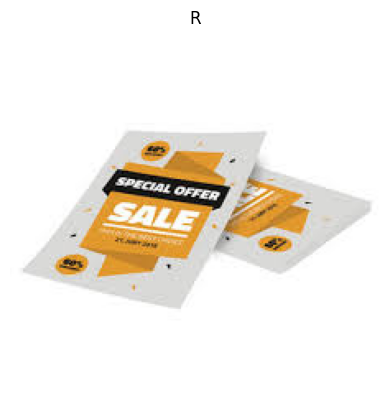

In [17]:
# Visualizing images from the directories
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Pre-processing Data

In [18]:
# Creating the data loaders or data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen= ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


Found 17600 images belonging to 2 classes.
Found 4400 images belonging to 2 classes.


## Baseline Model

Modeled after the Tiny VGG achitecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

Trying a baseline model on the raw dataset (non-augmented) and seeing how well it does...

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [23]:
model_1 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/5
550/550 [==============================] - 39s 68ms/step - loss: 0.4468 - accuracy: 0.7961 - val_loss: 0.3721 - val_accuracy: 0.8409
Epoch 2/5
550/550 [==============================] - 44s 80ms/step - loss: 0.3655 - accuracy: 0.8486 - val_loss: 0.3685 - val_accuracy: 0.8570
Epoch 3/5
550/550 [==============================] - 38s 69ms/step - loss: 0.3270 - accuracy: 0.8663 - val_loss: 0.3628 - val_accuracy: 0.8691
Epoch 4/5
550/550 [==============================] - 37s 68ms/step - loss: 0.2835 - accuracy: 0.8866 - val_loss: 0.3597 - val_accuracy: 0.8614
Epoch 5/5
550/550 [==============================] - 41s 74ms/step - loss: 0.2414 - accuracy: 0.9043 - val_loss: 0.3959 - val_accuracy: 0.8518


In [24]:
model_1.evaluate(test_data)

138/138 [==============================] - 8s 57ms/step - loss: 0.3959 - accuracy: 0.8518


[0.3958652913570404, 0.8518182039260864]

In [25]:
# Plot validation and training curves
def plot_loss_curves(history):
  """
  Returns seperte loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs were ran

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

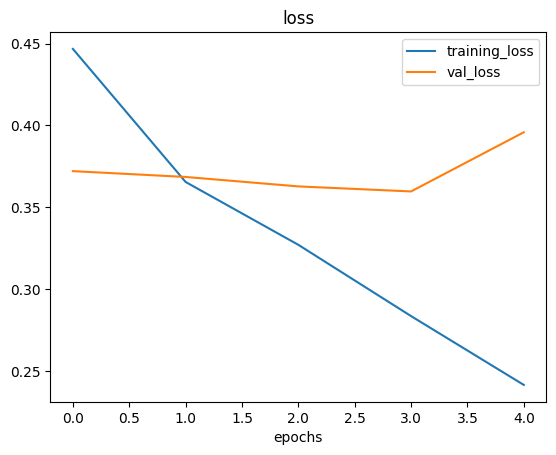

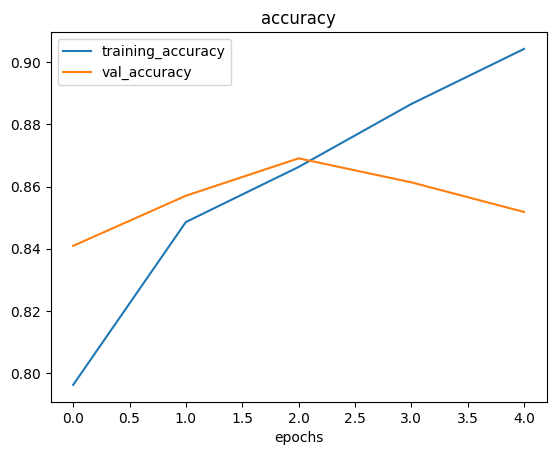

In [26]:
plot_loss_curves(history_1)